## User Behaviour on Twitter
Unsupervised clustering and interpreting.

In [85]:
#import libs
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import  tqdm #NOT NEEDED, JUST USED WHEN WRITING THE NOTEBOOK
pd.set_option('display.max_columns', None)
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

In [3]:
#loading
egoalter = pd.read_csv('EgoAlterProfiles.txt',delimiter='\t')
#egonet = pd.read_csv('./EgoNetworks.txt',delimiter='\t')
egotimes = pd.read_csv('EgoTimelines.txt',delimiter='\t',encoding='latin-1')

In [4]:
egoalter.head()

,ID,IsEgo,followers_count,friends_count,statuses_count,utc_offset,lang,created_at,protected
0,1,True,30.0,28,9.0,NaN,en,Wed Oct 26 03:30:32 +0000 2011,False
1,2,True,2.0,8,7.0,-14400.0,en,Mon Jul 27 20:46:32 +0000 2009,False
2,3,True,1.0,0,0.0,NaN,fr,Mon Apr 23 20:57:26 +0000 2012,False
3,4,True,3.0,3,68.0,NaN,en,Sun Feb 14 07:50:39 +0000 2010,False
4,5,True,65.0,118,748.0,NaN,fr,Mon Jun 11 14:17:06 +0000 2012,False


In [5]:
egotimes[200:400]

,replyto_userid,retweeted_userid,id,tweetid,created_at,hashtags,urls,mentions_ids,retweet_count,egoID,retweetedUserID,replytoUserID,metionID
200,NaN,NaN,605458456,523333693134622720,Sat Oct 18 04:44:10 +0000 2014,NaN,NaN,131556965,0,5,NaN,NaN,2423603
201,NaN,162670016.0,605458456,413801463979458560,Thu Dec 19 22:42:11 +0000 2013,NaN,NaN,"162670016,424891673,324662307",5,5,NaN,NaN,1792569
202,NaN,NaN,605458456,527763081762717696,Thu Oct 30 10:04:58 +0000 2014,IciCestParis,NaN,NaN,0,5,NaN,NaN,NaN
203,NaN,NaN,605458456,527719935527878656,Thu Oct 30 07:13:31 +0000 2014,NaN,NaN,NaN,0,5,NaN,NaN,NaN
204,NaN,NaN,605458456,527252905972494338,Wed Oct 29 00:17:43 +0000 2014,NaN,NaN,NaN,0,5,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,NaN,NaN,605458456,424146092771778560,Fri Jan 17 11:48:03 +0000 2014,NaN,NaN,NaN,0,5,NaN,NaN,NaN
396,NaN,NaN,605458456,394447458828161025,Sun Oct 27 12:56:17 +0000 2013,skyrim,NaN,NaN,0,5,NaN,NaN,NaN
397,NaN,NaN,605458456,347778837368684544,Thu Jun 20 18:11:50 +0000 2013,NaN,http://t.co/n3Am0xdPgI,NaN,0,5,NaN,NaN,NaN
398,NaN,NaN,605458456,322070627999707136,Wed Apr 10 19:36:36 +0000 2013,BARCAPSG,NaN,NaN,0,5,NaN,NaN,NaN


### Features used for clustering
- followers count
- friends count
- followers-friends ratio
- proportion of tweets
- proportion of RT
- proportion of replies
- days since account creation
- average number of statuses per month
- average number of hashtags per post
- average number of URLs per post
- average number of mentions per post
- average number of retweets per tweet

In [6]:
def extract_info(df):
    
    n = len(df)
    n_replies = n - np.sum(df['replyto_userid'].isnull())
    n_rt = n - np.sum(df['retweeted_userid'].isnull())
    mentions = df[df['mentions_ids'].notnull()].mentions_ids
    n_mentions = len([x for xs in mentions for x in xs.split(',')])
    
    retweeted = np.nansum(df['retweet_count'])
    
    # number of hashtags
    hashtags = df[df['hashtags'].notnull()].hashtags
    n_hashtags = len([x for xs in hashtags for x in xs.split(',')])
    
    # number of urls per tweet
    urls = df[df['urls'].notnull()].urls
    n_urls = len([x for xs in urls for x in xs.split(',')])
    
    return n, n_replies, n_mentions, n_rt, n_hashtags, n_urls, retweeted

In [7]:
isEgo = egoalter.loc[egoalter['IsEgo']]

In [8]:
ego_intersect = set(egotimes['egoID'].unique()).intersection(set(isEgo['ID']))
columns = ['id','n_statuses', 'n_replies','n_mentions','n_rt','n_hashtags','n_urls','retweeted']
stats = pd.DataFrame(0, index=np.arange(len(ego_intersect)), columns=columns)

for i, _id in tqdm(enumerate(ego_intersect)):
    n, n_replies, n_mentions, n_rt, n_hashtags, n_urls, retweeted = extract_info(egotimes.loc[egotimes['egoID']==_id])
    stats.iloc[i].id = _id
    stats.iloc[i].n_statuses = n
    stats.iloc[i].n_replies = n_replies
    stats.iloc[i].n_mentions = n_mentions
    stats.iloc[i].n_rt = n_rt
    stats.iloc[i].n_hashtags = n_hashtags
    stats.iloc[i].n_urls = n_urls
    stats.iloc[i].retweeted = retweeted

17244it [05:37, 51.12it/s]


In [9]:
merged = isEgo.merge(stats, how='left', left_on='ID', right_on='id')
merged.head()

,ID,IsEgo,followers_count,friends_count,statuses_count,utc_offset,lang,created_at,protected,id,n_statuses,n_replies,n_mentions,n_rt,n_hashtags,n_urls,retweeted
0,1,True,30.0,28,9.0,NaN,en,Wed Oct 26 03:30:32 +0000 2011,False,1.0,9.0,4.0,8.0,0.0,0.0,0.0,0.0
1,2,True,2.0,8,7.0,-14400.0,en,Mon Jul 27 20:46:32 +0000 2009,False,2.0,7.0,2.0,2.0,0.0,1.0,3.0,0.0
2,3,True,1.0,0,0.0,NaN,fr,Mon Apr 23 20:57:26 +0000 2012,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,True,3.0,3,68.0,NaN,en,Sun Feb 14 07:50:39 +0000 2010,False,4.0,68.0,0.0,0.0,0.0,0.0,60.0,0.0
4,5,True,65.0,118,748.0,NaN,fr,Mon Jun 11 14:17:06 +0000 2012,False,5.0,742.0,334.0,375.0,103.0,118.0,29.0,26408.0


In [10]:
inactive = (merged.friends_count == 0) & (merged.followers_count == 0)
merged['followers_ratio'] = (merged['followers_count']/(merged['friends_count'] + 0.01))
merged.loc[inactive,'followers_ratio'] = 1

merged['n_tweets'] = merged['n_statuses'] - merged['n_replies'] - merged['n_rt']
merged['prop_tweets'] = merged['n_tweets']/merged['n_statuses']
merged['prop_replies'] = merged['n_replies']/merged['n_statuses']
merged['prop_rt'] = merged['n_rt']/merged['n_statuses']
merged['avg_hashtags'] = merged['n_hashtags']/merged['n_statuses']
merged['avg_urls'] = merged['n_urls']/merged['n_statuses']
merged['avg_mentions'] = merged['n_mentions']/merged['n_statuses']
merged['avg_retweeted'] = (merged['retweeted']/merged['n_tweets']).replace(np.inf, 0)
merged['created_at'] = pd.to_datetime(merged['created_at'], format='%a %b %d %H:%M:%S %z %Y')
end_date = merged.created_at.max()
merged['account_age_months'] = ((end_date - merged.created_at).dt.days/30) + 0.01
merged['statuses_per_month'] = merged['statuses_count']/merged['account_age_months']
merged.head()

,ID,IsEgo,followers_count,friends_count,statuses_count,utc_offset,lang,created_at,protected,id,n_statuses,n_replies,n_mentions,n_rt,n_hashtags,n_urls,retweeted,followers_ratio,n_tweets,prop_tweets,prop_replies,prop_rt,avg_hashtags,avg_urls,avg_mentions,avg_retweeted,account_age_months,statuses_per_month
0,1,True,30.0,28,9.0,NaN,en,2011-10-26 03:30:32+00:00,False,1.0,9.0,4.0,8.0,0.0,0.0,0.0,0.0,1.071046,5.0,0.555556,0.444444,0.000000,0.000000,0.000000,0.888889,0.000000,36.676667,0.245388
1,2,True,2.0,8,7.0,-14400.0,en,2009-07-27 20:46:32+00:00,False,2.0,7.0,2.0,2.0,0.0,1.0,3.0,0.0,0.249688,5.0,0.714286,0.285714,0.000000,0.142857,0.428571,0.285714,0.000000,64.010000,0.109358
2,3,True,1.0,0,0.0,NaN,fr,2012-04-23 20:57:26+00:00,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.643333,0.000000
3,4,True,3.0,3,68.0,NaN,en,2010-02-14 07:50:39+00:00,False,4.0,68.0,0.0,0.0,0.0,0.0,60.0,0.0,0.996678,68.0,1.000000,0.000000,0.000000,0.000000,0.882353,0.000000,0.000000,57.310000,1.186529
4,5,True,65.0,118,748.0,NaN,fr,2012-06-11 14:17:06+00:00,False,5.0,742.0,334.0,375.0,103.0,118.0,29.0,26408.0,0.550801,305.0,0.411051,0.450135,0.138814,0.159030,0.039084,0.505391,86.583607,29.010000,25.784212


In [11]:
cols = ['followers_count','friends_count','statuses_count', 'account_age_months',
        'statuses_per_month','followers_ratio','prop_tweets', 'prop_replies','prop_rt',
        'avg_hashtags','avg_urls','avg_mentions']
features = merged[cols].fillna(0)

In [41]:
features.set_index('ID').describe()

,followers_count,friends_count,statuses_count,account_age_months,statuses_per_month,followers_ratio,prop_tweets,prop_replies,prop_rt,avg_hashtags,avg_urls,avg_mentions
count,34006.000000,34006.000000,3.400600e+04,34006.000000,34006.000000,34006.000000,34006.000000,34006.000000,34006.000000,34006.000000,34006.000000,34006.000000
mean,56.604511,68.490061,4.483272e+02,26.648642,16.856397,39.142005,0.323153,0.115620,0.068313,0.094698,0.096359,0.249363
std,953.436514,344.940809,6.748816e+03,18.094187,174.167148,1879.330302,0.410767,0.245612,0.189213,0.330004,0.256844,0.448269
min,0.000000,0.000000,0.000000e+00,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000e+00,11.643333,0.000000,0.052604,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,8.000000,1.000000e+00,23.876667,0.035150,0.363306,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.000000,37.000000,1.100000e+01,39.043333,0.671855,1.000000,0.727273,0.067467,0.000000,0.000000,0.001258,0.422831
max,124195.000000,24956.000000,1.082327e+06,104.476667,22893.471057,253800.000000,1.000000,1.000000,1.000000,12.000000,4.000000,8.500000


### To do: feature scaling and clustering

In [12]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
df = ((features-features.min())/(features.max()-features.min()))*20

In [14]:
epses = [0.1, 1., 3., 5., 10., 20.]
min_samples = [5, 10, 50, 100, 500]
for eps in epses:
    for min_sample in min_samples: 
        dbscan = DBSCAN(eps=eps, min_samples=min_sample).fit(df)
        unique_labels = set(dbscan.labels_)
        try:
            sl = silhouette_score(df, dbscan.labels_)
        except:
            sl = -1.
        print(eps, min_sample, sl)

0.1 5 -0.46034120534238787
0.1 10 0.16886379875531604
0.1 50 0.28265100368423485
0.1 100 0.24079656323485768
0.1 500 -1.0
1.0 5 0.03535248806766365
1.0 10 0.0900939460406576
1.0 50 0.3205139971827859
1.0 100 0.38417014549928535
1.0 500 0.3338121016592919
3.0 5 0.45799471482773924
3.0 10 0.48774874187270645
3.0 50 0.4905940741986209
3.0 100 0.4876655497201395
3.0 500 0.4831279594713284
5.0 5 0.49043510609621216
5.0 10 0.4904529587511421
5.0 50 0.4906015475652597
5.0 100 0.4906637385523208
5.0 500 0.48491995865092996
10.0 5 0.4903578187281798
10.0 10 0.4903578187281798
10.0 50 0.4903802251235645
10.0 100 0.4903802251235645
10.0 500 0.4904010380853822
20.0 5 0.5751583300678177
20.0 10 0.5751583300678177
20.0 50 0.5751583300678177
20.0 100 0.5751583300678177
20.0 500 0.5751583300678177


In [ ]:
from sklearn.metrics import silhouette_score
epses = [20., 200.]
min_samples = [500, 5000]
for eps in epses:
    for min_sample in min_samples: 
        dbscan = DBSCAN(eps=eps, min_samples=min_sample).fit(df)
        unique_labels = set(dbscan.labels_)
        sl = silhouette_score(df, dbscan.labels_)
        print(eps, min_sample, sl)

20.0 500 0.5751583300678177
20.0 5000 0.5751583300678177


In [13]:
def find_average_user(X, labels):
    uniq_labels = sorted(list(set(labels)))
    average_users = []
    average_labels = []
    for label in uniq_labels:
        inds = [labels == label]
        inds = inds[0]
        cluster_users = X.iloc[inds]
        if len(cluster_users) > 100:
            average_user = cluster_users.mean(axis=0)
            average_users.append(average_user)
            average_labels.append(label)
    return dict(zip(average_labels, average_users))

## DBSCAN

In [64]:
from sklearn.metrics import silhouette_score
eps = 1.
min_sample = 100
dbscan = DBSCAN(eps=eps, min_samples=min_sample).fit(df)
unique_labels = set(dbscan.labels_)
sl = 0. #silhouette_score(df, dbscan.labels_)
print(eps, min_sample, len(unique_labels), sl)
print(Counter(dbscan.labels_))

1.0 100 5 0.0
Counter({0: 16736, -1: 11306, 1: 4408, 3: 804, 2: 752})


In [65]:
unique_labels = set(dbscan.labels_)
unique_colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
color_dict = dict(zip(unique_labels, unique_colors))
labels = dbscan.labels_
colors = []
for label in labels:
    colors.append(color_dict[label])
print(unique_labels)

{0, 1, 2, 3, -1}


In [75]:
users = find_average_user(df, dbscan.labels_)
users_list = []
for k, v in users.items():
    users_list.append(v.values)
users_list = np.array(users_list)
users_list[:, 1]

array([0.1286804 , 0.01552125, 0.0265889 , 0.02821135, 0.01679174])

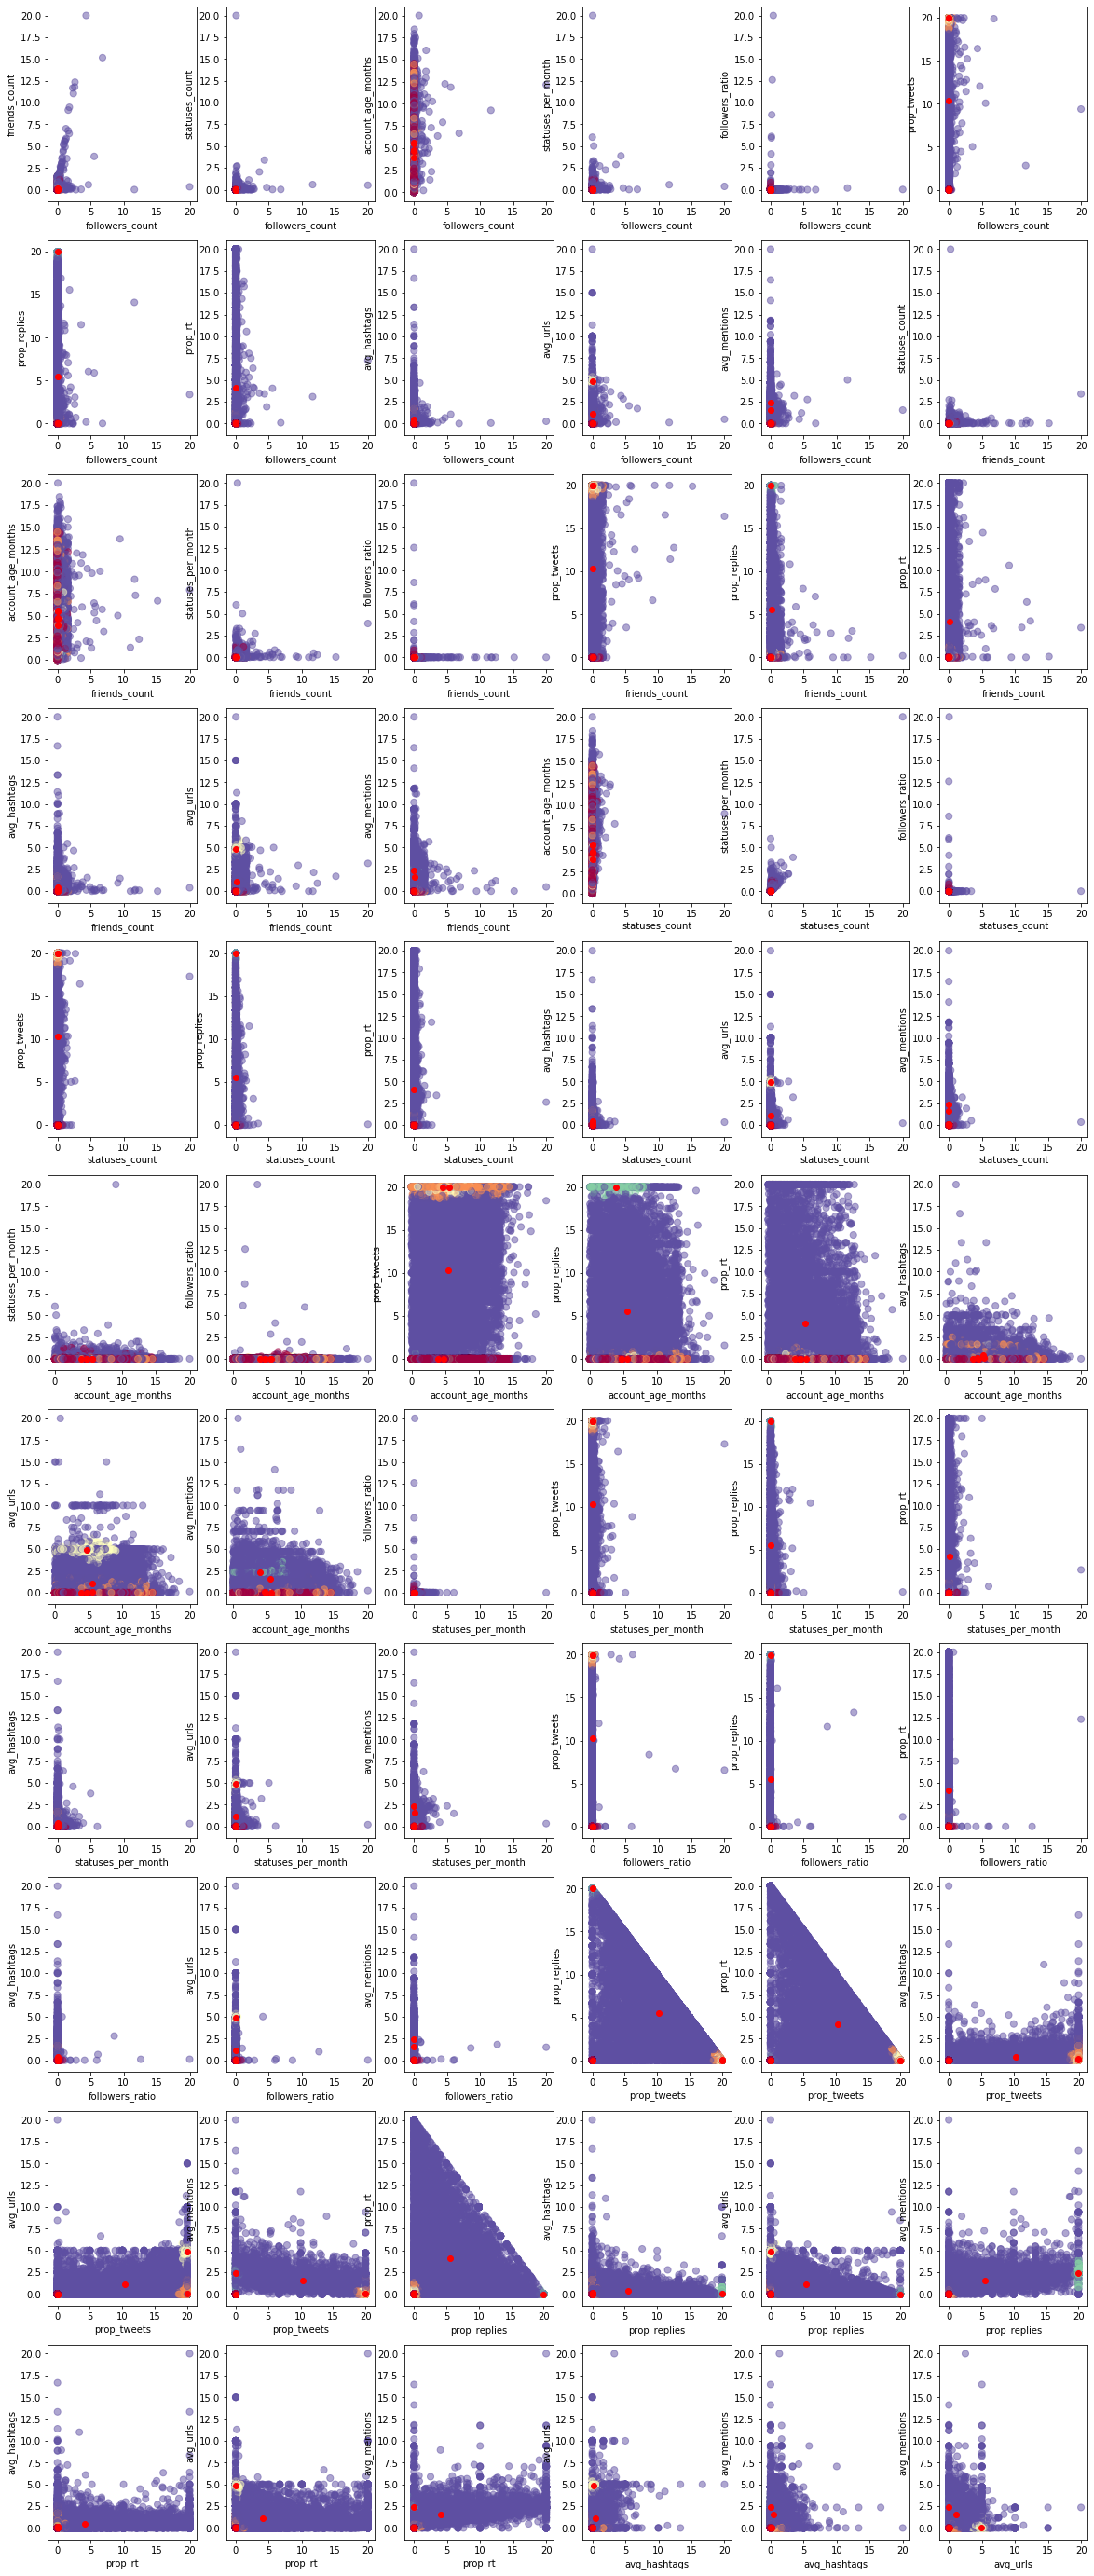

In [76]:
users = find_average_user(df, dbscan.labels_)

fig, ax_arr = plt.subplots(11, 6, figsize=(20, 50))
ax_arr = np.array(ax_arr).ravel()

k = 0
for i in range(len(cols) - 1):
    for j in range(i + 1, len(cols)):
        ax = ax_arr[k]
        k += 1
        #ax.scatter(df[cols[i]], df[cols[j]], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
        ax.scatter(df[cols[i]], df[cols[j]], c=colors, s=50, alpha=0.5)
        ax.set_xlabel(cols[i])
        ax.set_ylabel(cols[j])
        ax.scatter(users_list[:, i], users_list[:, j], c='red')
        #for k, v in users.items():
        #    ax.scatter(v[i], v[j], color='red')
            #ax.annotate('dot ' + str(k), (new_average_vector[0], new_average_vector[1]), c='black')

In [77]:
print(users)

{-1: followers_count        0.024655
friends_count          0.128680
statuses_count         0.021889
account_age_months     5.489455
statuses_per_month     0.038183
followers_ratio        0.006667
prop_tweets           10.322961
prop_replies           5.526045
prop_rt                4.105001
avg_hashtags           0.423444
avg_urls               1.101868
avg_mentions           1.580651
dtype: float64, 0: followers_count       0.001171
friends_count         0.015521
statuses_count        0.001703
account_age_months    4.777385
statuses_per_month    0.003241
followers_ratio       0.001339
prop_tweets           0.000000
prop_replies          0.000000
prop_rt               0.000000
avg_hashtags          0.000000
avg_urls              0.000000
avg_mentions          0.000000
dtype: float64, 1: followers_count        0.002173
friends_count          0.026589
statuses_count         0.000750
account_age_months     5.611802
statuses_per_month     0.002155
followers_ratio        0.001252
prop_twee

Interpretation:
0. Incognito
1. Many tweets, small amount of everything else, so content generation
2. The same as 1, but many urls, so advertisment 
3. Social, many replys and mentions (celebrity)
-1. Active user, many everything

## KMEANS

[[ 1.09189879e-03  1.52409895e-02  1.07881791e-03  2.61527056e+00
   3.79037138e-03  4.67974165e-04  7.91366972e-13  2.60680366e-13
   1.46771484e-13 -1.69309011e-14 -2.57016630e-14 -4.55191440e-15]
 [ 1.06681510e-02  6.47467308e-02  7.87426280e-03  5.60060693e+00
   1.26131858e-02  2.99897307e-03  1.93182877e+01  3.77334268e-01
   3.04378077e-01  2.96298124e-01  1.30508530e+00  3.19254550e-01]
 [ 1.22786629e-02  5.10675511e-02  5.63796517e-03  4.78776184e+00
   1.35315092e-02  5.75438898e-03  2.27139599e+00  1.68268257e+01
   9.01778318e-01  1.42127059e-01  2.61906251e-01  2.39485782e+00]
 [ 3.06830431e-02  1.42739125e-01  2.89139282e-02  5.97411627e+00
   4.36250206e-02  2.44390356e-03  1.07421182e+01  6.54537341e+00
   2.71250838e+00  2.99919387e-01  6.17939056e-01  1.42132635e+00]
 [ 1.69248940e-02  1.50327735e-01  1.93028376e-02  4.10663114e+00
   5.19330427e-02  1.04847774e-02  3.40646014e+00  1.99877856e+00
   1.45947613e+01  6.06795764e-01  1.08534874e+00  2.44906541e+00]
 [ 1.

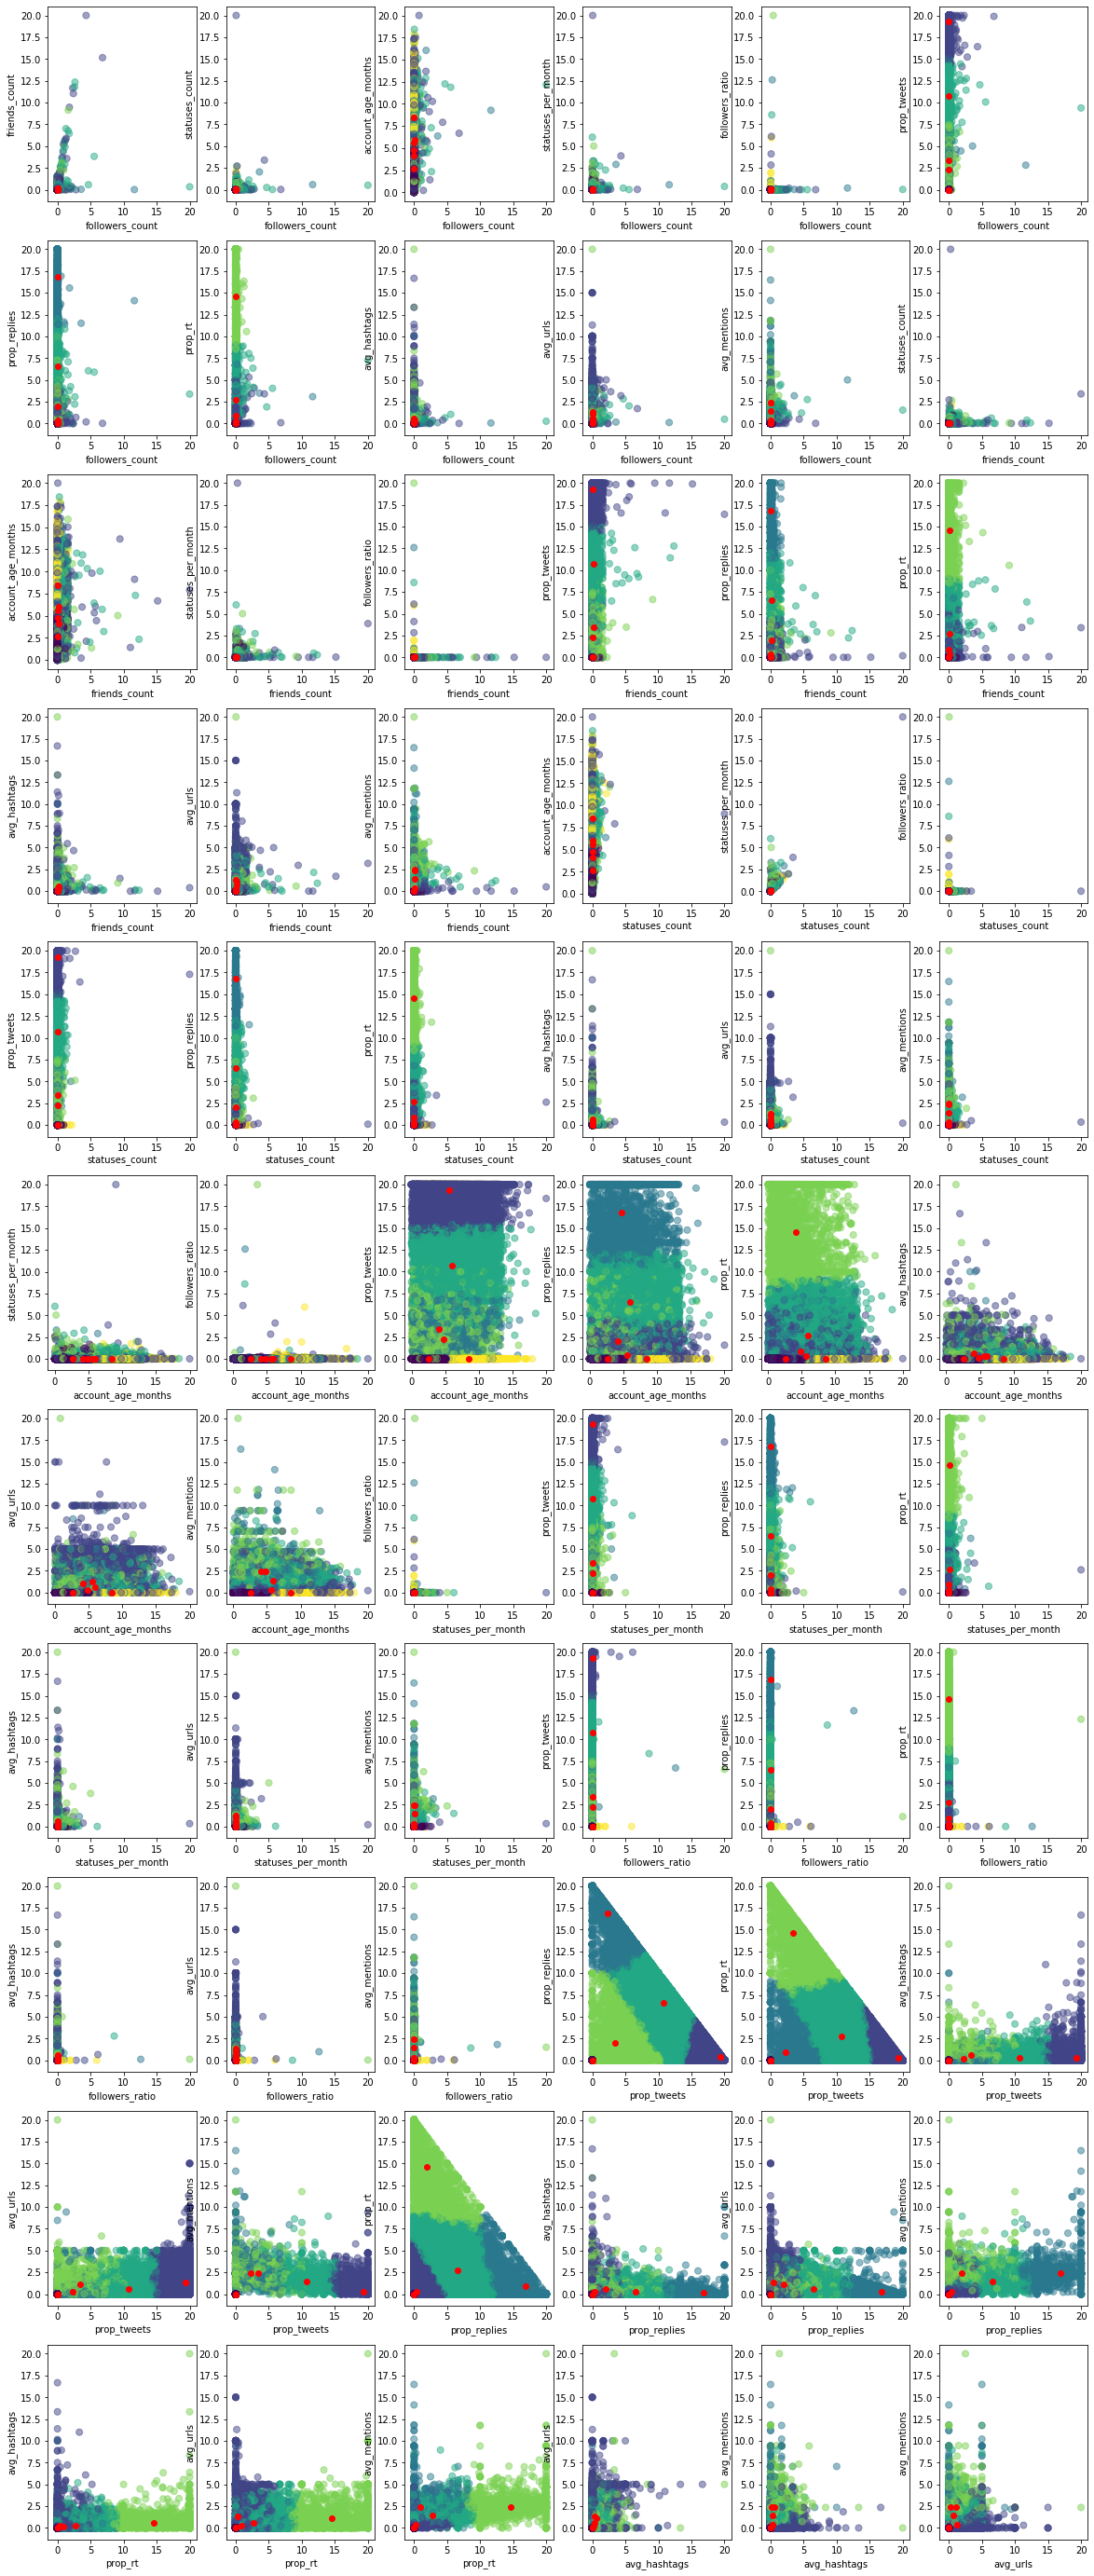

In [14]:
kmeans = KMeans(n_clusters=6).fit(df)
centroids = kmeans.cluster_centers_
print(centroids)
users = find_average_user(df, kmeans.labels_)
users_list = []
for k, v in users.items():
    users_list.append(v.values)
users_list = np.array(users_list)

#dbscan = DBSCAN(eps=eps, min_samples=min_sample).fit(df)

fig, ax_arr = plt.subplots(11, 6, figsize=(20, 50))
ax_arr = np.array(ax_arr).ravel()

k = 0
for i in range(len(cols) - 1):
    for j in range(i + 1, len(cols)):
        ax = ax_arr[k]
        k += 1
        ax.scatter(df[cols[i]], df[cols[j]], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
        #ax.scatter(df[cols[i]], df[cols[j]], c=colors, s=50, alpha=0.5)
        ax.set_xlabel(cols[i])
        ax.set_ylabel(cols[j])
        ax.scatter(users_list[:, i], users_list[:, j], c='red')

Calculating the number of people in each cluster.

In [74]:
from collections import Counter
cluster_users_dict = dict(Counter(kmeans.labels_))
cluster_users_dict = dict(sorted(cluster_users_dict.items()))

Looking at average user for every cluster

In [20]:
users = find_average_user(df, kmeans.labels_)
users

{0: followers_count       0.001092
 friends_count         0.015241
 statuses_count        0.001079
 account_age_months    2.615271
 statuses_per_month    0.003790
 followers_ratio       0.000468
 prop_tweets           0.000000
 prop_replies          0.000000
 prop_rt               0.000000
 avg_hashtags          0.000000
 avg_urls              0.000000
 avg_mentions          0.000000
 dtype: float64,
 1: followers_count        0.010670
 friends_count          0.064756
 statuses_count         0.007890
 account_age_months     5.601436
 statuses_per_month     0.012624
 followers_ratio        0.002999
 prop_tweets           19.317810
 prop_replies           0.377712
 prop_rt                0.304478
 avg_hashtags           0.296285
 avg_urls               1.304987
 avg_mentions           0.319406
 dtype: float64,
 2: followers_count        0.012293
 friends_count          0.051110
 statuses_count         0.005644
 account_age_months     4.789360
 statuses_per_month     0.013531
 followers_r

In [19]:
users_arr = []
for k, v in users.items():
    users_arr.append(v)
users_arr = np.array(users_arr)
users_arr

array([[1.09189879e-03, 1.52409895e-02, 1.07881791e-03, 2.61527056e+00,
        3.79037138e-03, 4.67974165e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.06702120e-02, 6.47555770e-02, 7.89033941e-03, 5.60143591e+00,
        1.26240373e-02, 2.99861967e-03, 1.93178101e+01, 3.77711872e-01,
        3.04478001e-01, 2.96285377e-01, 1.30498714e+00, 3.19406020e-01],
       [1.22925608e-02, 5.11101679e-02, 5.64436144e-03, 4.78935972e+00,
        1.35313913e-02, 5.76121027e-03, 2.26704769e+00, 1.68335112e+01,
        8.99441095e-01, 1.42125582e-01, 2.62153745e-01, 2.39614811e+00],
       [3.06633158e-02, 1.42653783e-01, 2.88692350e-02, 5.97093731e+00,
        4.35914303e-02, 2.44279315e-03, 1.07378082e+01, 6.54922079e+00,
        2.71297099e+00, 2.99837872e-01, 6.17584573e-01, 1.42121689e+00],
       [1.69248940e-02, 1.50327735e-01, 1.93028376e-02, 4.10663114e+00,
        5.19330427e-02, 1.04847774e-02, 3.40646014e+00, 1.99

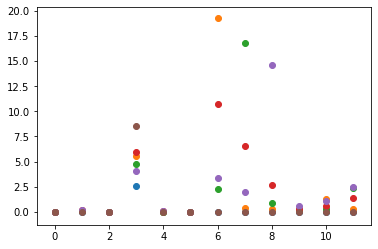

In [21]:
for i in range(6):
    plt.scatter(range(12), users_arr[i])
plt.show()

We can see, that not all the features are really different from cluster to cluster/ Features which shows differences are 3, 6, 7, 8, 10, 11, which are [account_age_months, prop_tweets, prop_replies, prop_rt, avg_urls, avg_mentions] Let's plot bar plot to see how different are they. 

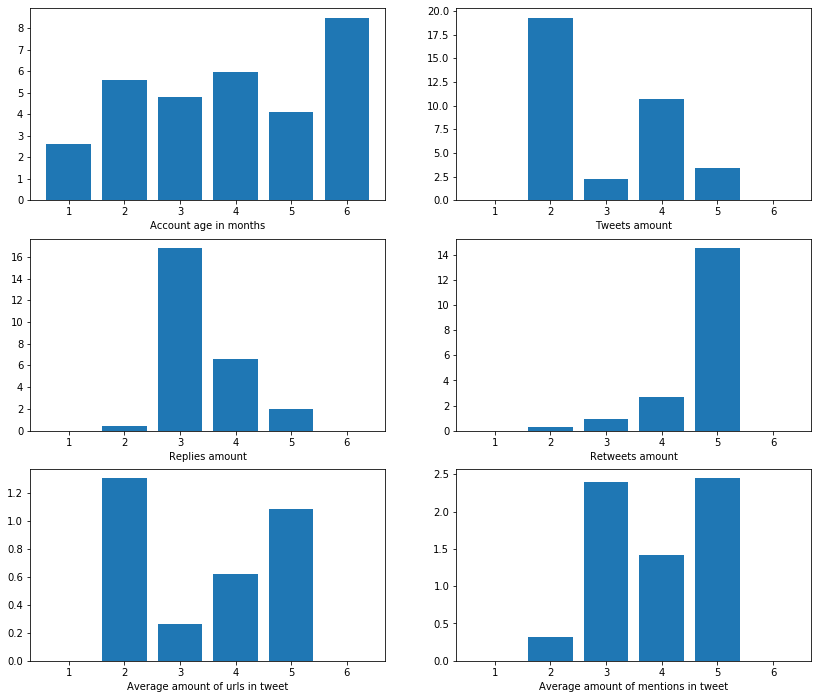

In [32]:
meaningful_features = [3, 6, 7, 8, 10, 11]
features_names = ['Account age in months', 
                     'Tweets amount',
                     'Replies amount',
                     'Retweets amount',
                     'Average amount of urls in tweet',
                     'Average amount of mentions in tweet']
fig, ax_arr = plt.subplots(3, 2, figsize=(14, 12))
ax_arr = np.array(ax_arr).ravel()

        
for feature, ax, name in zip(meaningful_features, ax_arr, features_names):
    ax.bar(range(1, 7), users_arr[:, feature])
    ax.set_xlabel(name)
fig.savefig('Clustes_barplot.png')

On the plot we can see the most meaningful characteristics (the one, which are differ between clusters) of average user in each cluster. The amount of users in clusters are not the same, but differ less than in ten times, so the groups of the users valuable. 
1. $31\%$ of analyzed users. Having the smallest values of different features, including the account lifetime. That means that the account was created for some purposes and has not being used as a normal account. For example, a person created it for spying on their spouses, of it may be a bot, which collects some statistics and information on other users. 
2. $24\%$ of analyzed users. This type of user has the biggest characteristics on urls in tweets and on tweets, but relatively small replies, retweets and mentions, which means -- small interaction with other people. This category might be some company/program, and the amount of tweets with urls is for advertising movie, product or company.
3. $8\%$ of analyzed users. This type of user has many mentions and replies and relatively less on other features, which means he or she is mainly communicate through the twiiter, contact different persons and discuss with them tweets and answers.
4. $13\%$ of analyzed users. This type does not prevail on each kind of possible twitter activities, but is in the middle of any of them. Which means it is regular active user. Uses all the functions of the applications, but not follow some purpose as popularity or advertising.
5. $6\%$ of analyzed users. The fifth type has small amount of generating contents and replies, so this users does not communicate with the others that much, but has the biggest rates on mentions and retweets. This might be a celebrity who retweets a lot about her/his new movie/music album or political activist, that retweets most important news in the sphere. 
6. $18\%$ of analyzed users. The sixth cluster has almost none tweets, mentions or any activity. But, the account age are one of the biggests. So, this is the reader. The person, who reads a lot, but does not communicate with anyone through the twitter or generate new content. May be the person who cares a lot about sharing personal information, so Incognito.

For features where difference are the biggest (since we normalized all the features to one scale we can compare them) let's plot the points in the cluster and try to see the pattern of splitting. 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

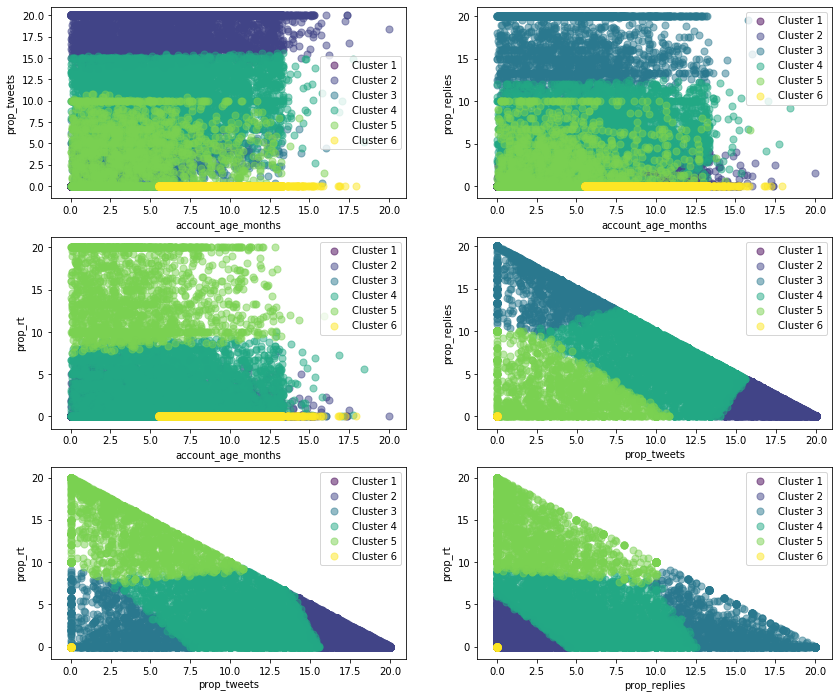

In [86]:
from matplotlib import cm

fig, ax_arr = plt.subplots(3, 2, figsize=(14, 12))
ax_arr = np.array(ax_arr).ravel()

new_cols = ['account_age_months', 
                     'prop_tweets',
                     'prop_replies',
                     'prop_rt']

viridis = cm.get_cmap('viridis', 256)
colors = viridis(np.linspace(0, 1, 6))
group = kmeans.labels_.astype(float)
k = 0
for i in range(len(new_cols) - 1):
    for j in range(i + 1, len(new_cols)):
        ax = ax_arr[k]
        k += 1
        for g in np.unique(group):
            ix = np.where(group == g)
            ax.scatter(df[new_cols[i]].values[ix], df[new_cols[j]].values[ix], c = colors[int(g)], 
                                                     label='Cluster ' + str(int(g) + 1), s=50, alpha=0.5)
        ax.set_xlabel(new_cols[i])
        ax.set_ylabel(new_cols[j])
        ax.legend()
fig.savefig('Clustering.png')

In [89]:
users_amount = np.array(list(cluster_users_dict.values())).sum() #amount of users
clusters_user_percent = np.array(list(cluster_users_dict.values())) / users_amount
clusters_user_percent

array([0.31056284, 0.24298653, 0.07419279, 0.1301241 , 0.05978357,
       0.18235017])

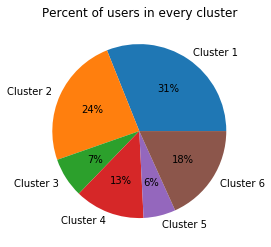

In [94]:
# distribution of the users amount through clusters
plt.pie(clusters_user_percent, labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6'], 
        autopct='%1.0f%%')
plt.title('Percent of users in every cluster')
plt.savefig('users_per_cluster_pie.png')